# Total Energy Expenditure by Mass Scatter Plot

The plot that will be reproduced in this example is a log-log scatter plot of total energy expenditure (kcal/day) against mass (kg) as published by Pontzer et al. (2014) in PNAS (doi: [10.1073/pnas.1316940111](http://dx.doi.org/10.1073/pnas.1316940111)). Log-log plots of this sort are fairly common in biological anthropology, and this one has some of the common complications: multiple fitted lines, confidence intervals, different colored points for different groups, and some annotations.

![](images/energyexpenditure_plot.png)

The data underlying this plot are included in the supplementary material of the paper and have been extracted and made available in my bioanth datasets repository.

## Some preliminaries

First, I always change the R option for importing strings (I find that the default convert to factor causes more problems than it solves).

In [1]:
options(stringsAsFactors=F)

Next, import the data. The resulting data frame has five variables: species, order, captive, mass (in kg), and tee (total energy expenditure in kcal/day).

In [2]:
dset = read.csv(url("https://raw.githubusercontent.com/ryanraaum/bioanth-datasets/master/raw/energyexpenditure.csv"))
str(dset)

'data.frame':	86 obs. of  5 variables:
 $ species: chr  "Microcebus_murinus" "Lepilemur_ruficaudatus" "Eulemur" "Lemur_catta" ...
 $ order  : chr  "Primates" "Primates" "Primates" "Primates" ...
 $ captive: chr  "no" "no" "no" "no" ...
 $ mass   : num  0.064 0.77 1.84 2.24 2.21 4.9 7.12 12 72.2 46.6 ...
 $ tee    : num  28 121 146 146 217 ...


While it is possible to do log transformations on the fly, I find that doing so will lead to complications down the line, so it is best to just create new logged variables in the working data frame.

In [3]:
dset$logmass = log10(dset$mass)
dset$logtee = log10(dset$tee)

Because the target plot shows primates in red and nonprimates in black, it will be useful to have a variable for this color difference. 

In [4]:
point_color = ifelse(dset$order == "Primates", "red", "black")
table(point_color)

point_color
black   red 
   67    19 

In addition, the nonprimates and the non-captive primates have filled circles while the captive primates have non-filled ones, so a variable for this will be useful as well. Because there are missing data in the `captive` variable (unknown/missing for the nonprimates), and we want three different fills (black, red, none), the fill factor has to be constructed a little differently than the simple `ifelse` I used just above for the outline color.

In [5]:
# first make the variable and set everything to black
# adjustcolor used to adjust transparency to match the appearance of the published plot
point_fill = rep(adjustcolor("black", alpha=0.5), nrow(dset)) 

# then update the entries that we don't want to be black
point_fill[dset$captive == "no"] = adjustcolor("red", alpha=0.5)
point_fill[dset$captive == "yes"] = "white" # background is white, so will appear to be no fill
table(point_fill)

point_fill
#00000080 #FF000080     white 
       67         8        11 

The target plot has three different OLS regression lines on it:

1. Nonprimates (black line)
2. Primates (red line)
3. Primates without the mouse lemur (red dashed line)

So these data subsets and regression models will be useful.

In [6]:
nonprimates = subset(dset, order != "Primates")
allprimates = subset(dset, order == "Primates")
subprimates = subset(allprimates, species != "Microcebus_murinus")

nonprimatesfit = lm(logtee ~ logmass, data=nonprimates)
allprimatesfit = lm(logtee ~ logmass, data=allprimates)
subprimatesfit = lm(logtee ~ logmass, data=subprimates)

## Base R

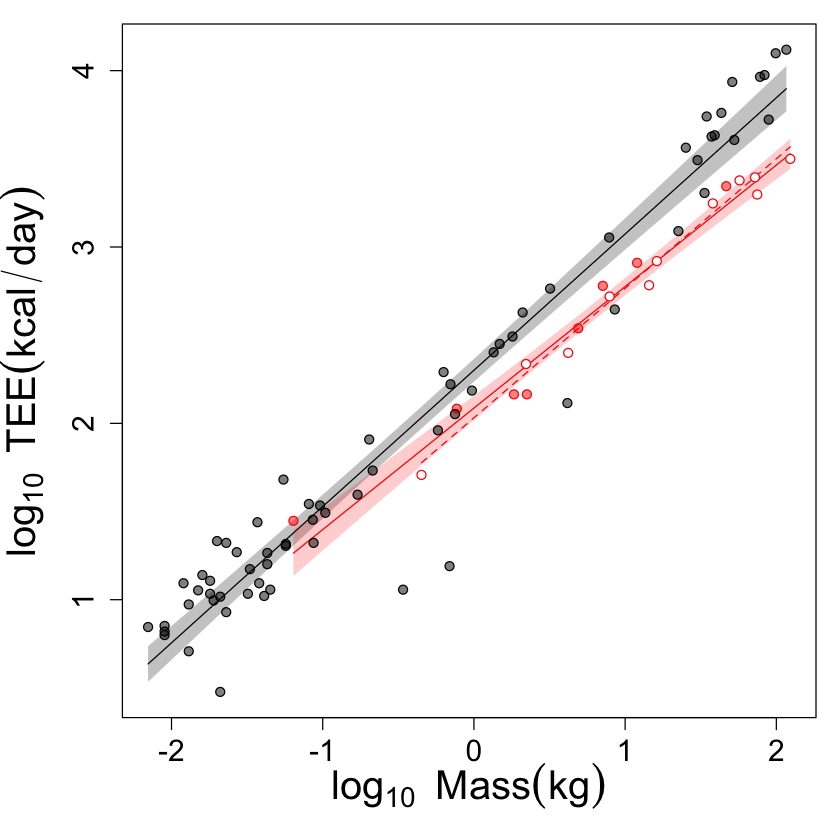

In [7]:
# To match the published plot, the axis legends need to be larger than the R default,
# and to make them fit into the plot area, the margins need to be changed.
# Because "par" settings are semi-permanent, I save the default settings in order
# to reset them at the end.
old.par = par(mar=c(5.1,5.1,1.0,1.0)) 

# set up the plot without any data points or lines
plot(logtee ~ logmass, 
     data=dset, 
     type='n', # 'none' - no points will be plotted
     xlab=expression(log[10]~~Mass(kg)),
     ylab=expression(log[10]~~TEE(kcal/day)),
     # the numbers below were arrived at by trial and error
     cex.lab=2,    # double the size of the labels
     cex.axis=1.5) # make the axis numbers 1.5 times default size

# the lines, confidence intervals, and points need to added in the right order
# to ensure proper visibility - the lines have to go on top of the confidence 
# intervals, and the points need to go on last.

# First, the non-primates confidence interval and line
# (I am departing slightly from the published plot here by limiting the area
#  of the line and confidence interval to the range of available data)
# Generate a range of x-axis values (logmasses) to use in calculating the confidence interval
np_massrange = seq(min(nonprimates$logmass), max(nonprimates$logmass), length.out=100)
# calculate the point, upper, and lower estimates from the model
np_interval = predict(nonprimatesfit, 
                      newdata=data.frame(logmass=np_massrange), 
                      interval='confidence')
# plot a filled polygon covering the area between the upper and lower limits
polygon(c(rev(np_massrange), np_massrange),           # x values
        c(rev(np_interval[,3]), np_interval[,2]),     # y values
        col='grey80', border=NA)
# add the fitted line
lines(c(min(np_massrange), max(np_massrange)),                  
      c(np_interval[1,1], np_interval[length(np_massrange),1]))

# Next, the all primates confidence interval and line, same as above with different data
ap_massrange = seq(min(allprimates$logmass), max(allprimates$logmass), length.out=100)
ap_interval = predict(allprimatesfit, 
                      newdata=data.frame(logmass=ap_massrange), 
                      interval='confidence')
polygon(c(rev(ap_massrange), ap_massrange),           
        c(rev(ap_interval[,3]), ap_interval[,2]),     
        col=adjustcolor("red", alpha=.2),
        border=NA)
lines(c(min(ap_massrange), max(ap_massrange)),                  
      c(ap_interval[1,1], ap_interval[length(ap_massrange),1]), 
      col="red")

# Then add the primates without mouse lemur fitted line
sb_minmax = c(min(subprimates$logmass), max(subprimates$logmass))
sb_fitted = predict(subprimatesfit,
                    newdata=data.frame(logmass=sb_minmax))
lines(sb_minmax,  # x values for ends of line
      sb_fitted,  # y values for ends of line
      col="red",
      lty=2)      # dotted line

# Add the points
# first plot filled circles
with(dset, points(logmass, logtee, pch=16, col=point_fill))
# then overplot with open circles
with(dset, points(logmass, logtee, pch=1, col=point_color))

# Finally, reset plotting default parameters
par(old.par)

## ggplot2

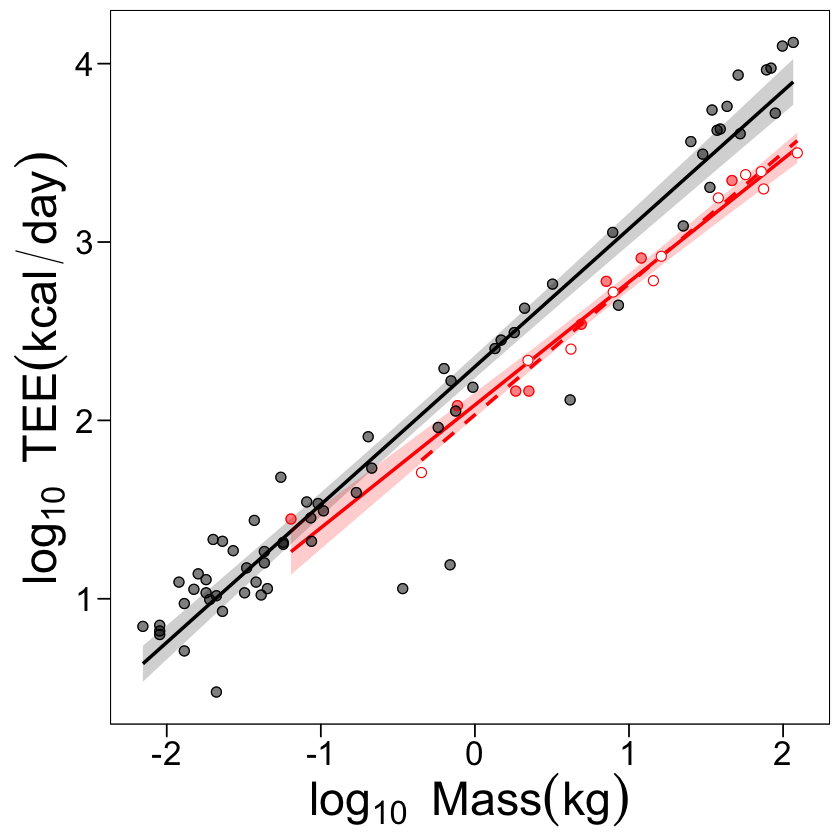

In [8]:
library(ggplot2)
library(ggthemes) # for the simple theme_base

plt = ggplot(dset, aes(x=logmass, y=logtee)) +
        # no gridlines, shading, etc.
        theme_base() + 
        # get rid of outer frame
        theme(plot.background = NULL) +  
        # make the axis tick labels a little bigger
        theme(axis.text = element_text(size=rel(1.25))) + 
        # make the axis legend text larger as well
        theme(axis.title=element_text(size=rel(1.75))) +
        # set the x- and y-axis legends
        xlab(expression(log[10]~~Mass(kg))) +
        ylab(expression(log[10]~~TEE(kcal/day))) +
        # add the non-primates line and confidence interval
        geom_smooth(data=nonprimates, aes(x=logmass, y=logtee), method="lm", color="black") +
        # add the all primates line and confidence interval
        geom_smooth(data=allprimates, aes(x=logmass, y=logtee), method="lm", color="red", 
                    fill="red", alpha=0.2) +
        # add the primates without mouse lemur line (without confidence interval)
        geom_smooth(data=subprimates, aes(x=logmass, y=logtee), method="lm", color="red", 
                    linetype=2, se=F) +
        # add the filled circles
        geom_point(color=point_fill, size=2.5) +
        # add the open circles on top
        geom_point(color=point_color, shape=1, size=2.5)

# show the plot
plt

## lattice

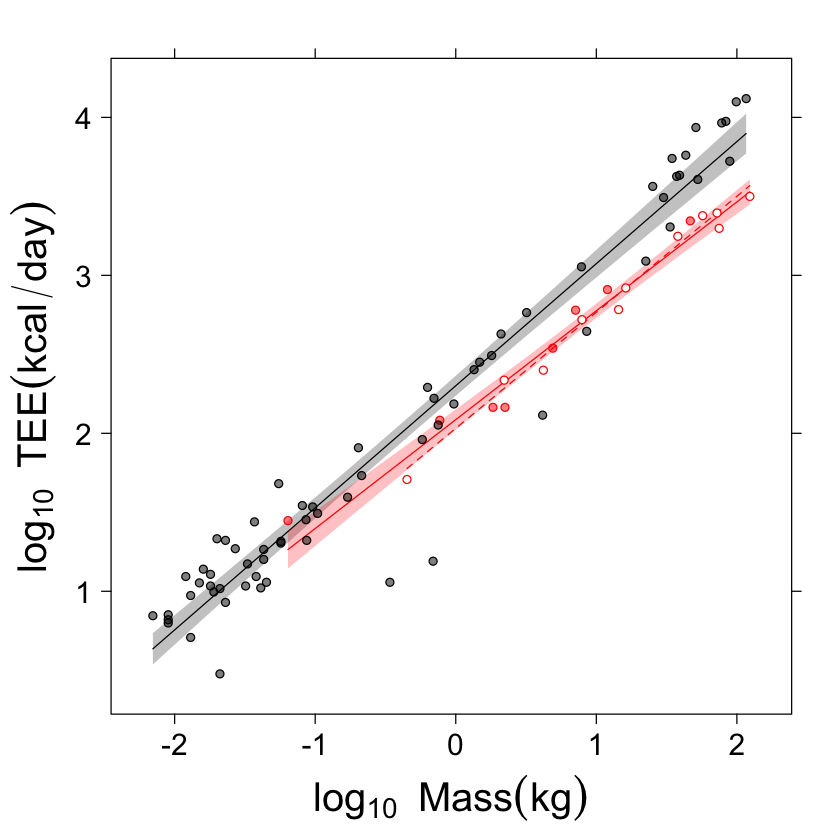

In [10]:
library(lattice)
library(latticeExtra) # for panel.smoother to add lines and confidence intervals

xyplot(logtee ~ logmass, data=dset,
       # set up the axis labels, double the default size (cex=2)
       xlab=list(label=expression(log[10]~~Mass(kg)), cex=2),
       ylab=list(label=expression(log[10]~~TEE(kcal/day)), cex=2),
       # increase the size of the axis numbers
       scales=list(x=list(cex=1.5), y=list(cex=1.5)),
       panel=function(x, y) {
           # add the line and confidence interval for the non primates
           panel.smoother(nonprimates$logmass, nonprimates$logtee, method="lm", col="black")
           # add the line and confidence interval for all primates
           panel.smoother(allprimates$logmass, allprimates$logtee, method="lm", col="red")
           # add the line primates without the mouse lemur
           panel.smoother(subprimates$logmass, subprimates$logtee, method="lm", col="red", 
                          lty=2, se=F)
           # add the points (point type 21 can have separate outline and fill colors)
           panel.xyplot(x,y,pch=21,col=point_color,fill=point_fill)
      })  


## Annotations

It is **possible** to add all the annotations present in the original published plot programatically in R, but I'm not sure that it is advisable. It's not pretty or particularly easy in any of the R plotting worlds. I'll do it below as an example, but I'm pretty certain that the annotations were added manually to the published plot.

First, we will need to extract the necessary values from the models (coefficients, df, etc.). All of the formatting and rounding here is to ensure that the numbers have exactly two decimal places.

In [11]:
# numbers from the non-primates model
np_df = nonprimatesfit$df.residual                                            # df
np_r2 = format(round(summary(nonprimatesfit)$r.squared, 2), nsmall=2)         # R2
np_b0 = format(round(nonprimatesfit$coefficients[1], 2), nsmall=2)            # intercept
np_b1 = format(round(nonprimatesfit$coefficients[2], 2), nsmall=2)            # slope
np_e0 = format(round(summary(nonprimatesfit)$coefficients[1,2], 2), nsmall=2) # intercept s.e.
np_e1 = format(round(summary(nonprimatesfit)$coefficients[2,2], 2), nsmall=2) # slope s.e.

# numbers from the all primates model (same order as above)
ap_df = allprimatesfit$df.residual
ap_r2 = format(round(summary(allprimatesfit)$r.squared, 2), nsmall=2)
ap_b0 = format(round(allprimatesfit$coefficients[1], 2), nsmall=2)
ap_b1 = format(round(allprimatesfit$coefficients[2], 2), nsmall=2)
ap_e0 = format(round(summary(allprimatesfit)$coefficients[1,2], 2), nsmall=2)
ap_e1 = format(round(summary(allprimatesfit)$coefficients[2,2], 2), nsmall=2)

# numbers from the primates without mouse lemur model (same order as above)
sp_df = subprimatesfit$df.residual
sp_r2 = format(round(summary(subprimatesfit)$r.squared, 2), nsmall=2)
sp_b0 = format(round(subprimatesfit$coefficients[1], 2), nsmall=2)
sp_b1 = format(round(subprimatesfit$coefficients[2], 2), nsmall=2)
sp_e0 = format(round(summary(subprimatesfit)$coefficients[1,2], 2), nsmall=2)
sp_e1 = format(round(summary(subprimatesfit)$coefficients[2,2], 2), nsmall=2)

Next, create the formatted text for each annotation; each line of each annotation needs to be created separately. The syntax used here is the R `plotmath` system; type `?plotmath` at an R prompt or search online for full details.

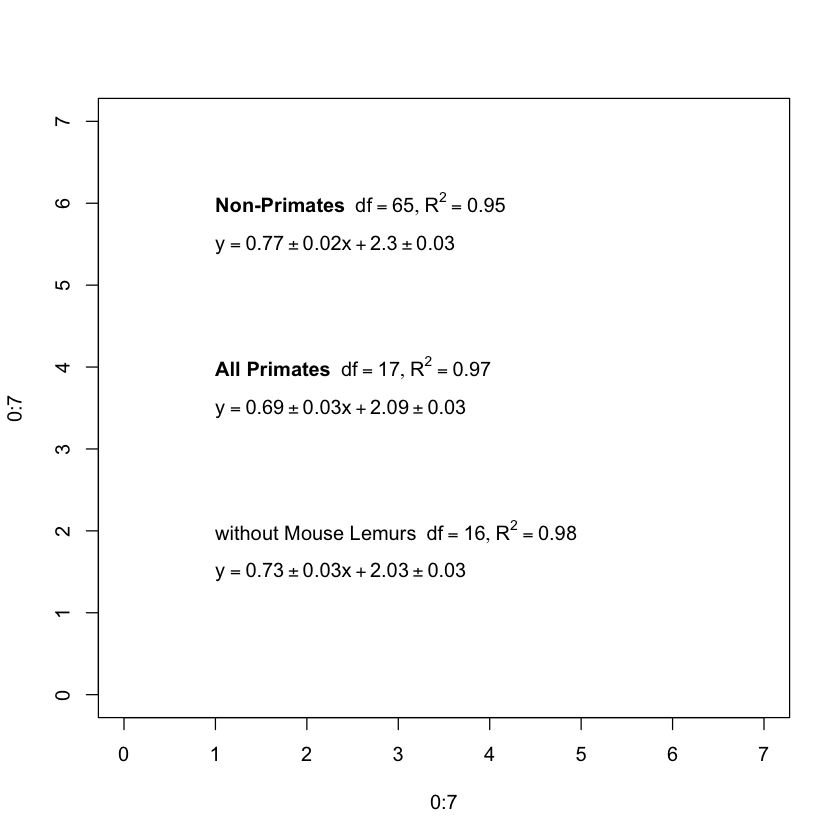

In [12]:
# non primates annotation text
np_lab1 = paste("bold('Non-Primates') ~~ list(df == ", np_df, ", R^2 == ", np_r2, ")")
np_lab2 = paste("y == ", np_b1, "%+-%", np_e1, "*x + ", np_b0, "%+-%", np_e0)

# all primates annotation text
ap_lab1 = paste("bold('All Primates') ~~ list(df == ", ap_df, ", R^2 == ", ap_r2, ")")
ap_lab2 = paste("y == ", ap_b1, "%+-%", ap_e1, "*x + ", ap_b0, "%+-%", ap_e0)

# primates without mouse lemur annotation text
sp_lab1 = paste("'without Mouse Lemurs' ~~ list(df == ", sp_df, ", R^2 == ", sp_r2, ")")
sp_lab2 = paste("y == ", sp_b1, "%+-%", sp_e1, "*x + ", sp_b0, "%+-%", sp_e0)

# show that these are what we want
# the symbols can only be shown on a plot surface, so just use a quick empty plot
plot(0:7, 0:7, type='n')
text(1,6,labels=parse(text=np_lab1), adj=0)
text(1,5.5,labels=parse(text=np_lab2), adj=0)
text(1,4,labels=parse(text=ap_lab1), adj=0)
text(1,3.5,labels=parse(text=ap_lab2), adj=0)
text(1,2,labels=parse(text=sp_lab1), adj=0)
text(1,1.5,labels=parse(text=sp_lab2), adj=0)

Set up the light red color for the primate annotations text.

In [13]:
lightred = adjustcolor("red", alpha=0.6)

Ok, now that we have the annotation text, we can add them to the plots. 

### Annotations on base R plot

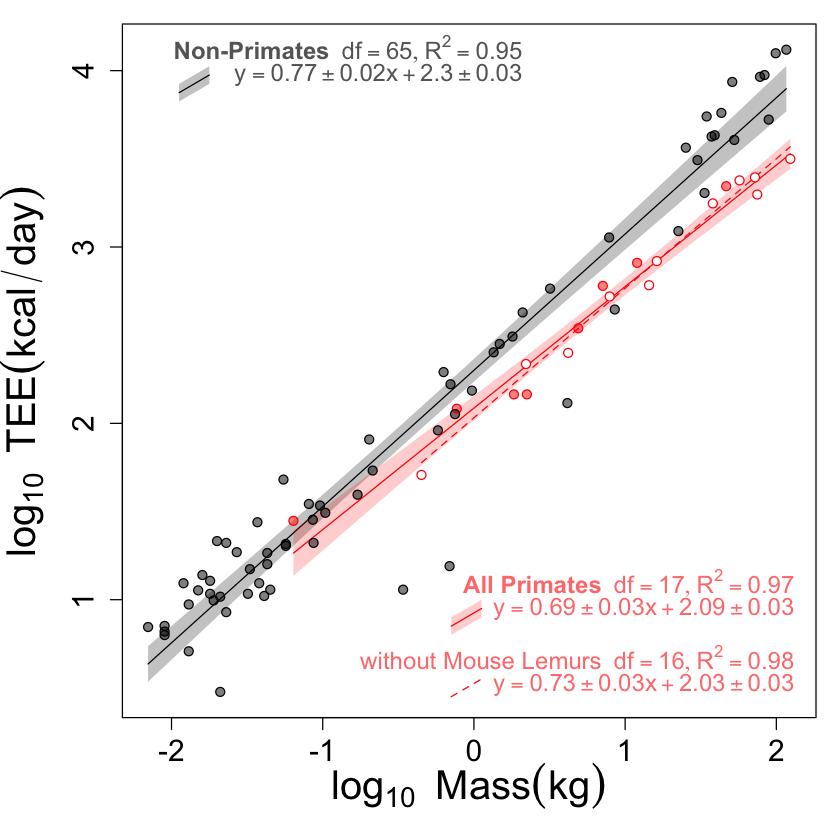

In [14]:
# Need to make the plot first, skip down to see annotation code
old.par = par(mar=c(5.1,5.1,1.0,1.0)) 

plot(logtee ~ logmass, data=dset, type='n', 
     xlab=expression(log[10]~~Mass(kg)),
     ylab=expression(log[10]~~TEE(kcal/day)),
     cex.lab=2, cex.axis=1.5) 

np_massrange = seq(min(nonprimates$logmass), max(nonprimates$logmass), length.out=100)
np_interval = predict(nonprimatesfit, 
                      newdata=data.frame(logmass=np_massrange), 
                      interval='confidence')
polygon(c(rev(np_massrange), np_massrange),      
        c(rev(np_interval[,3]), np_interval[,2]),
        col='grey80', border=NA)
lines(c(min(np_massrange), max(np_massrange)),                  
      c(np_interval[1,1], np_interval[length(np_massrange),1]))

ap_massrange = seq(min(allprimates$logmass), max(allprimates$logmass), length.out=100)
ap_interval = predict(allprimatesfit, 
                      newdata=data.frame(logmass=ap_massrange), 
                      interval='confidence')
polygon(c(rev(ap_massrange), ap_massrange),           
        c(rev(ap_interval[,3]), ap_interval[,2]),     
        col=adjustcolor("red", alpha=.2),
        border=NA)
lines(c(min(ap_massrange), max(ap_massrange)),                  
      c(ap_interval[1,1], ap_interval[length(ap_massrange),1]), 
      col="red")

sb_minmax = c(min(subprimates$logmass), max(subprimates$logmass))
sb_fitted = predict(subprimatesfit,
                    newdata=data.frame(logmass=sb_minmax))
lines(sb_minmax, sb_fitted, col="red", lty=2)      

with(dset, points(logmass, logtee, pch=16, col=point_fill))
with(dset, points(logmass, logtee, pch=1, col=point_color))

#
# Add annotations
#

# get a value for the text height to use in vertical spacing
txthght = 1.5*strheight("XXX", cex=1.2)

# starting location for top left annotation
# these are the x,y coordinates that will be the right end of the text
x0 = 0.4; y0 = 4.1
# add text, 
text(x0, y0, pos=2, cex=1.2, col='grey40', labels=parse(text=np_lab1))
text(x0, y0-txthght, pos=2, cex=1.2, col='grey40', labels=parse(text=np_lab2))

# starting location for bottom right annotation
x1 = 2.2; y1 = 0.5
# add text
text(x1, y1+4*txthght, pos=2, cex=1.2, col=lightred, labels=parse(text=ap_lab1))
text(x1, y1+3*txthght, pos=2, cex=1.2, col=lightred, labels=parse(text=ap_lab2))
text(x1, y1+txthght, pos=2, cex=1.2, col=lightred, labels=parse(text=sp_lab1))
text(x1, y1, pos=2, cex=1.2, col=lightred, labels=parse(text=sp_lab2))

# add the mini line with confidence interval to the non primates annotation
polygon(c(-1.95, -1.75, -1.75, -1.95),  # x values for four corners
        c(3.925, 4.025, 3.925, 3.825),  # y values for four corners
        col='grey80', border=NA)
lines(c(-1.95, -1.75), c(3.875, 3.975)) # add line

# add the mini line with confidence interval to the non primates annotation
polygon(c(-0.15, 0.05, 0.05, -0.15),
        c(0.8, 0.9, 1.0, 0.9),     
        col=adjustcolor("red", alpha=0.2), border=NA)
lines(c(-0.15, 0.05), c(0.85, 0.95), col="red")

# add the mini line for the primates without mouse lemur annotation
lines(c(-0.15, 0.05), c(0.45, 0.55), col="red", lty=2)

# Finally, reset plotting default parameters
par(old.par)

### Annotations on ggplot2 plot

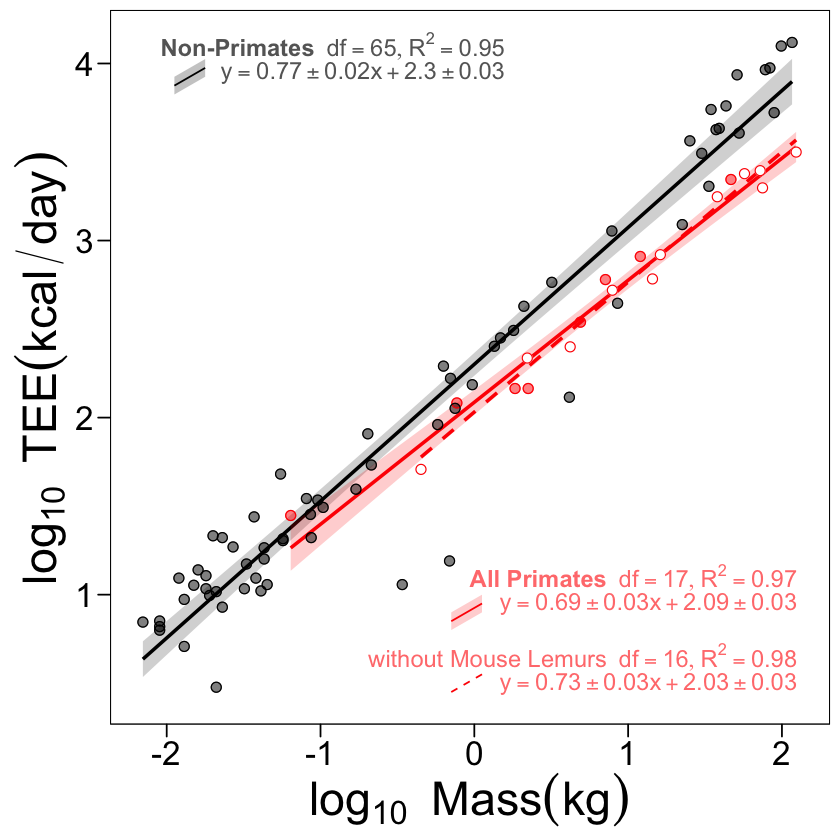

In [15]:
# we can use the plot object from above, so don't need to re-run the plotting code here

# set a text size and line spacing to use
# (used a bit of trial and error to get these values)
tsize = 5
lspacing = 0.15

# starting location for the top left annotations
# (again a bit of trial and error)
x0 = 0.2; y0 = 4.1

# add the top left labels to the plot
plt = plt + annotate("text", x=x0, y=y0, hjust=1, label=np_lab1, parse=T, 
                     size=tsize, color='grey40') +
            annotate("text", x=x0, y=y0-lspacing, hjust=1, label=np_lab2, parse=T, 
                     size=tsize, color='grey40') +
            annotate("polygon", fill="grey80", 
                     x=c(-1.95, -1.75, -1.75, -1.95), 
                     y=c(3.925, 4.025, 3.925, 3.825)) +
            annotate("line", x=c(-1.95, -1.75), y=c(3.875, 3.975))

# starting point for bottom right annotations
x1 = 2.1; y1 = 0.5

# add the bottom right labels to the plot
plt = plt + annotate("text", x=x1, y=y1+4*lspacing, hjust=1, label=ap_lab1, parse=T, 
                     size=tsize, color=lightred) +
            annotate("text", x=x1, y=y1+3*lspacing, hjust=1, label=ap_lab2, parse=T, 
                     size=tsize, color=lightred) +
            annotate("polygon", fill=adjustcolor("red", alpha=0.2), 
                     x=c(-0.15, 0.05, 0.05, -0.15),
                     y=c(0.8, 0.9, 1.0, 0.9)) +
            annotate("line", x=c(-0.15, 0.05), y=c(0.85, 0.95), col="red") +
            annotate("text", x=x1, y=y1+lspacing, hjust=1, label=sp_lab1, parse=T, 
                     size=tsize, color=lightred) +
            annotate("text", x=x1, y=y1, hjust=1, label=sp_lab2, parse=T, 
                     size=tsize, color=lightred) +
            annotate("line", x=c(-0.15, 0.05), y=c(0.45, 0.55), col="red", lty=2)

# show the plot
plt

### Annotations on lattice plot

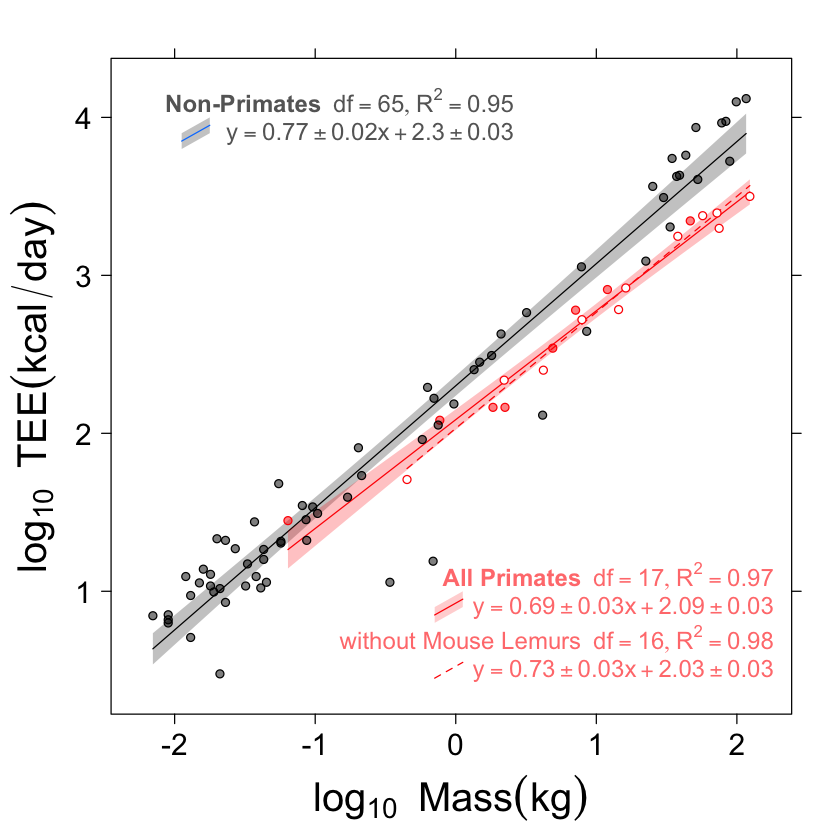

In [16]:
# starting location for the top left annotations
x0 = 0.5; y0 = 4.1

# starting point for bottom right annotations
x1 = 2.35; y1 = 0.5

# text size multiplier and line spacing
tcex = 1.2
lspacing = 0.2

xyplot(logtee ~ logmass, data=dset,
       xlab=list(label=expression(log[10]~~Mass(kg)), cex=2),
       ylab=list(label=expression(log[10]~~TEE(kcal/day)), cex=2),
       scales=list(x=list(cex=1.5), y=list(cex=1.5)),
       panel=function(x, y) {
           panel.smoother(nonprimates$logmass, nonprimates$logtee, method="lm", col="black")
           panel.smoother(allprimates$logmass, allprimates$logtee, method="lm", col="red")
           panel.smoother(subprimates$logmass, subprimates$logtee, method="lm", col="red", 
                          lty=2, se=F)
           panel.xyplot(x,y,pch=21,col=point_color,fill=point_fill)
           
           # add the top left annotations to the plot
           panel.text(x=x0, y=y0, pos=2, labels=parse(text=np_lab1), cex=tcex, col='grey40')
           panel.text(x=x0, y=y0-lspacing, pos=2, labels=parse(text=np_lab2), 
                      cex=tcex, col='grey40')
           panel.polygon(x=c(-1.95, -1.75, -1.75, -1.95), y=c(3.9, 4.0, 3.9, 3.8), 
                         col='grey80', border=NA)
           panel.lines(c(-1.95, -1.75), c(3.85, 3.95))
           
           # add the bottom right annotations to the plot
           panel.text(x=x1, y=y1+3*lspacing, pos=2, labels=parse(text=ap_lab1), 
                      cex=tcex, col=lightred)
           panel.text(x=x1, y=y1+2*lspacing, pos=2, labels=parse(text=ap_lab2), 
                      cex=tcex, col=lightred)
           panel.text(x=x1, y=y1+lspacing, pos=2, labels=parse(text=sp_lab1), 
                      cex=tcex, col=lightred)
           panel.text(x=x1, y=y1, pos=2, labels=parse(text=sp_lab2), 
                      cex=tcex, col=lightred)
           panel.polygon(x=c(-0.15, 0.05, 0.05, -0.15),y=c(0.8, 0.9, 1.0, 0.9),     
                         col=adjustcolor("red", alpha=0.2), border=NA)
           panel.lines(x=c(-0.15, 0.05), y=c(0.85, 0.95), col="red")
           panel.lines(c(-0.15, 0.05), c(0.45, 0.55), col="red", lty=2)
       })  

